# seq2seq模型——机器翻译

### 案例简介

seq2seq是神经机器翻译的主流框架，如今的商用机器翻译系统大多都基于其构建，在本案例中，我们将使用由NIST提供的中英文本数据训练一个简单的中英翻译系统，在实践中学习seq2seq的具体细节，以及了解机器翻译的基本技术。

### seq2seq模型

从根本上讲，机器翻译需要将输入序列（源语言中的单词）映射到输出序列（目标语言中的单词）。正如我们在课堂上讨论的那样，递归神经网络（RNN）可有效处理此类顺序数据。机器翻译中的一个重要难题是输入和输出序列之间没有一对一的对应关系。即，序列通常具有不同的长度，并且单词对应可以是不平凡的（例如，彼此直接翻译的单词可能不会以相同的顺序出现）。

为了解决这个问题，我们将使用一种更灵活的架构，称为seq2seq模型。该模型由编码器和解码器两部分组成，它们都是RNN。编码器将源语言中的单词序列作为输入，并输出RNN层的最终隐藏状态。解码器与之类似，除了它还具有一个附加的全连接层（带有softmax激活），用于定义翻译中下一个单词的概率分布。以此方式，解码器本质上用作目标语言的神经语言模型。关键区别在于，解码器将编码器的输出用作其初始隐藏状态，而不是零向量。

### 数据和代码

本案例使用了一个小规模的中英平行语料数据，并提供了一个简单的seq2seq模型实现，包括数据的预处理、模型的训练、以及简单的评测。

### 评分要求

分数由两部分组成，各占50%。第一部分得分为对于简单seq2seq模型的改进，并撰写实验报告，改进方式多样，下一小节会给出一些可能的改进方向。第二分部得分为测试数据的评测结果，我们将给出一个中文测试数据集（`test.txt`），其中每一行为一句中文文本，需要同学提交模型做出的对应翻译结果，助教将对于大家的提交结果统一机器评测，并给出分数。

### 改进方向

初级改进：
- 将RNN模型替换成GRU或者LSTM
- 使用双向的encoder获得更好的源语言表示
- 对于现有超参数进行调优，这里建议划分出一个开发集，在开发集上进行grid search，并且在报告中汇报开发集结果
- 引入更多的训练语料（如果尝试复杂模型，更多的训练数据将非常关键）

进阶改进：
- 使用注意力机制（注意力机制是一个很重要的NMT技术，建议大家优先进行这方面的尝试，具体有许多种变体，可以参考这个[综述](https://nlp.stanford.edu/pubs/emnlp15_attn.pdf)）
- 在Encoder部分，使用了字级别的中文输入，可以考虑加入分词的结果，并且将Encoder的词向量替换为预训练过的词向量，获得更好的性能

复杂改进：
- 使用beam search的技术来帮助更好的解码，对于beam-width进行调优
- 将RNN替换为Transformer模型，以及最新的改进变体

## 环境依赖

In [1]:
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

如果使用GPU，则将下面的变量设为`True`。

In [2]:
USE_CUDA = True

## 读取数据

我们将读取目录下的`cn-eng.txt`文件，其中每一行是一个平行句对，例子如下：

```
我很冷。    I am cold.
```

### 对于单词进行编号

这里引入了两个特殊符号，“SOS”即“Start of sentence”和“EOS”即“End of sentence”。他们会加到输入文本的两端，以控制解码过程。

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2 # Count SOS and EOS
      
    def index_words(self, sentence):
        if self.name == 'cn':    
            for word in sentence:
                self.index_word(word)
        else:
            for word in sentence.split(' '):
                self.index_word(word)

    def index_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

### 文本预处理

丢弃除了中文、字母和常用标点之外的符号。

In [4]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z\u4e00-\u9fa5.!?，。？]+", r" ", s)
    return s

读取平行语料，并进行清理。

In [5]:
def read_langs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s-%s.txt' % (lang1, lang2)).read().strip().split('\n')
    
    # Split every line into pairs and normalize
    pairs = [[normalize_string(s) for s in l.split('\t')] for l in lines]
    
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
        
    return input_lang, output_lang, pairs

### 过滤句子

样例为了加快训练，只保留了不长于10个单词的句对，真正实验中将更多数据考虑进来可能获得更好的效果。

In [6]:
MAX_LENGTH = 10

def filter_pair(p):
    return len(p[1].split(' ')) < MAX_LENGTH

def filter_pairs(pairs):
    return [pair for pair in pairs if filter_pair(pair)]

处理数据的全过程：

- 读取数据，每一行分别处理，将其转换成句对
- 对于文本进行处理，过滤无用符号
- 根据已有文本对于单词进行编号，构建符号到编号的映射


In [7]:
def prepare_data(lang1_name, lang2_name, reverse=False):
    input_lang, output_lang, pairs = read_langs(lang1_name, lang2_name, reverse)
    print("Read %s sentence pairs" % len(pairs))
    
    pairs = filter_pairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    
    print("Indexing words...")
    for pair in pairs:
        input_lang.index_words(pair[0])
        output_lang.index_words(pair[1])

    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepare_data('cn', 'eng', False)

# Print an example pair
print(random.choice(pairs))

Reading lines...
Read 90000 sentence pairs
Trimmed to 68898 sentence pairs
Indexing words...
['你的這雙拖鞋很萌。', 'your pair of slippers are very cute .']


## 将文本数据转换为张量

为了训练，我们需要将句子变成神经网络可以理解的东西（数字）。每个句子将被分解成单词，然后变成张量，其中每个单词都被索引替换（来自之前的Lang索引）。在创建这些张量时，我们还将附加EOS令牌以表示该句子已结束。

![](https://i.imgur.com/LzocpGH.png)

In [8]:
# Return a list of indexes, one for each word in the sentence
def indexes_from_sentence(lang, sentence):
    if lang.name == 'cn':
        return [lang.word2index[word] for word in sentence]
    else:
        return [lang.word2index[word] for word in sentence.split(' ')]

def variable_from_sentence(lang, sentence):
    indexes = indexes_from_sentence(lang, sentence)
    indexes.append(EOS_token)
    var = torch.LongTensor(indexes).view(-1, 1)
    if USE_CUDA: var = var.cuda()
    return var

def variables_from_pair(pair):
    input_variable = variable_from_sentence(input_lang, pair[0])
    target_variable = variable_from_sentence(output_lang, pair[1])
    return (input_variable, target_variable)

# 组件模型

## 编码器

In [9]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        
    def forward(self, word_inputs, hidden):
        # Note: we run this all at once (over the whole input sequence)
        seq_len = len(word_inputs)
        embedded = self.embedding(word_inputs).view(seq_len, 1, -1)
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        hidden = torch.zeros(self.n_layers, 1, self.hidden_size)
        if USE_CUDA: hidden = hidden.cuda()
        return hidden

## 解码器

In [10]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1):
        super(DecoderRNN, self).__init__()
        
        # Keep parameters for reference
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        
        # Define layers
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, word_input, last_hidden):
        # Note: we run this one step at a time        
        word_embedded = self.embedding(word_input).view(1, 1, -1) # S=1 x B x N
        rnn_output, hidden = self.rnn(word_embedded, last_hidden)

        rnn_output = rnn_output.squeeze(0)
        output = F.log_softmax(self.out(rnn_output))

        return output, hidden

# 训练

## 一次训练迭代

为了训练，我们首先通过编码器逐字运行输入语句，并跟踪每个输出和最新的隐藏状态。接下来，为解码器提供解码器的最后一个隐藏状态作为其第一隐藏状态，并向其提供`<SOS>`作为其第一输入。从那里开始，我们迭代地预测来自解码器的下一个单词。
    
### Teacher Forcing 和 Scheduled Sampling

"Teacher Forcing"指的是每次都基于完全准确的上文进行解码，这样训练模型收敛很快，但是会造成实际场景和训练场景有较大差别，因为实际场景上文也都是模型预测的，可能不准确，具体细节可参考[论文](http://minds.jacobs-university.de/sites/default/files/uploads/papers/ESNTutorialRev.pdf)。

观察Teacher Forcing的网络的输出，我们可以看到该网络语法连贯，但是偏离正确的翻译。可以将其为学会了如何听老师的指示，而未学习如何独自冒险。

解决强迫教师问题的方法称为“计划抽样”（[Scheduled Sampling](https://arxiv.org/abs/1506.03099)），它在训练时仅在使用目标值和预测值之间进行切换。我们将在训练时随机选择,有时我们将使用真实目标作为输入（忽略解码器的输出），有时我们将使用解码器的输出。

In [11]:
teacher_forcing_ratio = 0.5
clip = 5.0

def train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):

    # Zero gradients of both optimizers
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0 # Added onto for each word

    # Get size of input and target sentences
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    # Run words through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)
    
    # Prepare input and output variables
    decoder_input = torch.LongTensor([[SOS_token]])
    decoder_hidden = encoder_hidden # Use last hidden state from encoder to start decoder
    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    # Choose whether to use teacher forcing
    use_teacher_forcing = random.random() < teacher_forcing_ratio
    if use_teacher_forcing:
        
        # Teacher forcing: Use the ground-truth target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di] # Next target is next input

    else:
        # Without teacher forcing: use network's own prediction as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_variable[di])
            
            # Get most likely word index (highest value) from output
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]
            
            decoder_input = torch.LongTensor([[ni]]) # Chosen word is next input
            if USE_CUDA: decoder_input = decoder_input.cuda()

            # Stop at end of sentence (not necessary when using known targets)
            if ni == EOS_token: break

    # Backpropagation
    loss.backward()
    torch.nn.utils.clip_grad_norm(encoder.parameters(), clip)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), clip)
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item() / target_length

下面是用于辅助输出训练情况的函数

In [12]:
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (as_minutes(s), as_minutes(rs))

## 进行训练

In [13]:
hidden_size = 500
n_layers = 2
dropout_p = 0.05

# Initialize models
encoder = EncoderRNN(input_lang.n_words, hidden_size, n_layers)
decoder = DecoderRNN(hidden_size, output_lang.n_words, n_layers, dropout_p=dropout_p)

# Move models to GPU
if USE_CUDA:
    encoder.cuda()
    decoder.cuda()

# Initialize optimizers and criterion
learning_rate = 0.0001
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

以下设置变量用于绘制图标和跟踪进度：

In [14]:
# Configuring training
n_epochs = 50000
plot_every = 200
print_every = 1000

# Keep track of time elapsed and running averages
start = time.time()
plot_losses = []
print_loss_total = 0 # Reset every print_every
plot_loss_total = 0 # Reset every plot_every

要进行实际训练，我们会多次调用训练函数，并在进行过程中打印中间信息。

In [15]:
# Begin!
for epoch in range(1, n_epochs + 1):
    
    # Get training data for this cycle
    training_pair = variables_from_pair(random.choice(pairs))
    input_variable = training_pair[0]
    target_variable = training_pair[1]

    # Run the train function
    loss = train(input_variable, target_variable, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)

    # Keep track of loss
    print_loss_total += loss
    plot_loss_total += loss

    if epoch == 0: continue

    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print_summary = 'Epoch %d/%d, %s, %.4f' % (epoch, n_epochs, time_since(start, epoch / n_epochs), print_loss_avg)
        print(print_summary)

    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        plot_losses.append(plot_loss_avg)
        plot_loss_total = 0

/home/hotbaby/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/hotbaby/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
/home/hotbaby/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch 1000/50000, 0m 9s (- 7m 53s), 4.9899
Epoch 2000/50000, 0m 19s (- 7m 52s), 4.8160
Epoch 3000/50000, 0m 29s (- 7m 43s), 4.6054
Epoch 4000/50000, 0m 39s (- 7m 35s), 4.5283
Epoch 5000/50000, 0m 49s (- 7m 25s), 4.3715
Epoch 6000/50000, 0m 59s (- 7m 14s), 4.3377
Epoch 7000/50000, 1m 9s (- 7m 4s), 4.2935
Epoch 8000/50000, 1m 18s (- 6m 53s), 4.3427
Epoch 9000/50000, 1m 28s (- 6m 44s), 4.2572
Epoch 10000/50000, 1m 38s (- 6m 35s), 4.2823
Epoch 11000/50000, 1m 49s (- 6m 26s), 4.2930
Epoch 12000/50000, 1m 58s (- 6m 16s), 4.2108
Epoch 13000/50000, 2m 8s (- 6m 7s), 4.2121
Epoch 14000/50000, 2m 18s (- 5m 57s), 4.1766
Epoch 15000/50000, 2m 28s (- 5m 47s), 4.1863
Epoch 16000/50000, 2m 38s (- 5m 37s), 4.2225
Epoch 17000/50000, 2m 48s (- 5m 27s), 4.2010
Epoch 18000/50000, 2m 58s (- 5m 17s), 4.1689
Epoch 19000/50000, 3m 8s (- 5m 7s), 4.1980
Epoch 20000/50000, 3m 18s (- 4m 58s), 4.1343
Epoch 21000/50000, 3m 29s (- 4m 49s), 4.1937
Epoch 22000/50000, 3m 39s (- 4m 39s), 4.1615
Epoch 23000/50000, 3m 50s 

## 绘制训练loss

<Figure size 432x288 with 0 Axes>

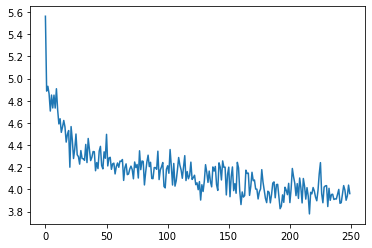

In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

# 保存模型

In [17]:
torch.save(encoder.state_dict(), './model_storage/baseline/encoder.pkl')
torch.save(decoder.state_dict(), './model_storage/baseline/decoder.pkl')

# 模型验证

In [18]:
def evaluate(sentence, max_length=MAX_LENGTH):
    input_variable = variable_from_sentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    
    # Run through encoder
    encoder_hidden = encoder.init_hidden()
    encoder_outputs, encoder_hidden = encoder(input_variable, encoder_hidden)

    # Create starting vectors for decoder
    decoder_input = torch.LongTensor([[SOS_token]]) # SOS
    if USE_CUDA:
        decoder_input = decoder_input.cuda()

    decoder_hidden = encoder_hidden
    
    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)
    
    # Run through decoder
    for di in range(max_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
        # Choose top word from output
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == EOS_token:
            decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni.item()])
            
        # Next input is chosen word
        decoder_input = torch.LongTensor([[ni]])
        if USE_CUDA: decoder_input = decoder_input.cuda()
    
    return decoded_words

随机选取一个句子进行验证。

In [19]:
def evaluate_randomly():
    pair = random.choice(pairs)
    
    output_words = evaluate(pair[0])
    output_sentence = ' '.join(output_words)
    
    print('>', pair[0])
    print('=', pair[1])
    print('<', output_sentence)
    print('')

In [20]:
evaluate_randomly()

> 他在樹下睡覺。
= he slept under a tree .
< he is a in . <EOS>



/home/hotbaby/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [21]:
evaluate('您的訂單已經提交了。')

/home/hotbaby/anaconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


['you', 'should', 'have', 'a', 'to', '.', '.', '.', '<EOS>']